In [1]:
import scipy 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
import time

from utils import *
%matplotlib inline

In [2]:
def get_equilibrium_time(series, min_points = 50):
    """
    Return the index at which equilibrium occur. 
    Equilibrium condition being that the moving window mean 
    is within half the standard deviation of the series mean.
    """
    series = np.array(series)
    mean = np.mean(series)
    std = np.std(series)
    for i in range(len(series)):
        window_mean = np.mean(series[:i])
        if abs(window_mean - mean) < 0.5 * std:
            return max(i, min_points)
    return min_points

def plot_series(series, x=None, ax=None, alpha=1, title='', color=None):
    if type(x) in [list, np.ndarray]:
        ax.plot(x, series, alpha=alpha, color=color)
    else:
        ax.plot(series, alpha=alpha, color=color)
    if title:
        ax.set_title("%s \nMean: %.2f Median: %.2f Std: %.2f" 
                     % (title, np.mean(series), np.median(series), np.std(series)))
    return ax


def smooth(signal, tn, input_t):
    output = np.zeros(len(input_t))
    for i in range(len(input_t)):
        t = input_t[i]
        normalise = 0
        hasval = False
        for j in range(len(tn)):
            delta_t = np.abs(t - tn[j])
            kernel_val = np.exp(- delta_t **2 / 2.0)
            normalise += kernel_val 
            output[i] += kernel_val * signal[j]
        output[i] = signal[np.abs(tn - t).argmin()]
    return output

def even_time_steps(yn, tn, stepsize=None, numpoints=100):
    mintime = np.min(tn)
    maxtime = np.max(tn)
    out_tn = np.zeros(tn.shape)
    if stepsize:
        row = np.arange(mintime, maxtime, stepsize)
    elif numpoints:
        row = np.linspace(mintime, maxtime, num=numpoints)
    else:
        row = np.linspace(mintime, maxtime, num=100)
    for r in range(tn.shape[0]):
        out_tn[r] = row
    out_yn = np.zeros(yn.shape)
    for i in range(tn.shape[0]):
        out_yn[i] = smooth(yn[i], tn[i], out_tn[i])
    return out_yn, out_tn

## Generalise 
---
Generalise the above simulation to take in any parameters

In [3]:
class Simulate_Continuous(object):
    def __init__(self, num_init=500, init_dist=None,
                 gamma=None, kappa=None, epsilon=None, mutation_rate=None,
                 tau=0.001, delta=0.01, num_generation=100,
                 walk_generator=None):
        self.gamma = gamma
        self.kappa = kappa
        self.epsilon = epsilon
        self.mutation_rate = mutation_rate / tau
        self.tau = tau
        self.delta = delta
        self.num_generation = num_generation
        self.walk_generator = walk_generator
        
        self.num_init = num_init
        if type(init_dist) != np.ndarray:
            self.init_dist = np.zeros(self.num_init)
        elif init_dist.size == num_init:
            self.init_dist = init_dist
        else:
            print "Initial distribution has size != num_init"
        
        self.realisations = []
    
    def realise(self, verbose=False):
        agents = self.init_dist
        population_n = [agents.size]
        pheno_mean = [agents.mean()]
        pheno_median = [np.median(agents)]
        t_n = [0]
        for n in range(self.num_generation):
            current_population = agents.size
            if current_population == 0:
                population_n.append(current_population)
                pheno_mean.append(0)
                pheno_median.append(0)
                t_n.append(t_n[-1] + self.tau)
                print "Extinction at generation: %i" % n
                break
            # obtain all the clocks = a 3 x current_population matrix
            bn = self.gamma # self.kappa * current_population
            walk_clocks = random_exp_time(current_population, self.mutation_rate)
            birth_clocks = random_exp_time(current_population, bn)
            death_clocks = [random_exp_time(1, 
                            self.kappa * current_population 
                                            + self.epsilon * (self.delta * agents[i])**2)[0]
                            for i in range(current_population)]
            clocks = np.concatenate([birth_clocks, death_clocks, walk_clocks])
            sorted_index = clocks.argsort()
            
            new_agents = []
            remove_index = []
            event_tally = [0, 0, 0]
            time_elapsed = 0
            num_updates = 0
            max_num_updates = sorted_index.size
            while time_elapsed < self.tau and num_updates < max_num_updates:
                index = sorted_index[num_updates]
                event = index // current_population
                event_tally[event] += 1
                agent_index = index % current_population
                if event == 0: # birth clock rang
                    new_agents.append(agents[agent_index])
                elif event == 1: # death knocks
                    remove_index.append(agent_index)
                elif event == 2: # mutation
                    agents[agent_index] += self.walk_generator()
                else: # something else going on, error
                    raise RuntimeError
                num_updates += 1
                time_elapsed = clocks[index]
            # update the agents
            agents = np.delete(agents, remove_index)
            agents = np.append(agents, new_agents)
            population_n.append(agents.size)
            t_n.append(t_n[-1] + time_elapsed)
            pheno_mean.append(agents.mean())
            pheno_median.append(np.median(agents))
            if n % 10 == 0 and verbose:
                print ("gen: %i, t: %.4f n_updates: %i prev_size: %i size: %i \n"
                       "events: %s b: %f d: %f\n" 
                       % (n, time_elapsed, num_updates, 
                          current_population, agents.size, str(event_tally), 
                          np.mean(birth_clocks), np.mean(death_clocks)))
        self.realisations.append({"agents":agents, "time":t_n, "population_n":population_n,
                                 "pheno_mean":pheno_mean, "pheno_median":pheno_median})
        return 
    
    def add_realisation(self, n, verbose=False):
        for i in range(n):
            np.random.seed(int(time.time()))
            self.realise(verbose=verbose)
        return 
    
    def report_avg_realisation(self):
        num_realisation = len(self.realisations)
        print "Number of realisations: %i" % num_realisation
        if num_realisation == 0:
            print "No realisation"
            return 
        agents_n = []
        extinction_time = []
        for item in self.realisations:
            if 0 in item['population_n']:
                extinction_time.append(item['population_n'].index(0))
            else:
                agents_n.append(item["agents"])
        
        num_extinction = len(extinction_time)
        if num_extinction > 0:
            p_extinct = float(num_extinction) / num_realisation
            avg_ext_time = np.mean(extinction_time)
            print ("%i extinction event out of %i realisation\np_extinct ~ %.2f\navg_ext_time: %.2f" 
                   % (num_extinction, num_realisation,p_extinct, avg_ext_time))
        fig, axes = plt.subplots(4, 2, figsize = (7 * 2, 4 * 7))
        if agents_n:
            agents_n = np.concatenate(agents_n)
            equi_mean = agents_n.mean()
            equi_num_agents = agents_n.size
            equi_median = np.median(agents_n)
            equi_std = np.std(agents_n)
            equi_iqr = stats.iqr(agents_n)
            
            axes[0][0].hist(agents_n, bins=compute_bins(agents_n))
            axes[0][0].set_title("Equilibrium Phenotype distribution\nMean: %.2f Median: %.2f Std: %.2f Total: %s"
                              % (equi_mean, equi_median, equi_std, equi_num_agents))
            axes[0][1].set_xlim(stats.iqr(agents_n, rng=(10, 90)))
            sns.distplot(agents_n, ax=axes[0][1])
            xmin, xmax = axes[0][0].get_xlim()
            ax0_xaxis = np.linspace(xmin, xmax, num=100)
            axes[0][1].plot(ax0_xaxis, stats.norm.pdf(ax0_xaxis, loc=equi_mean, scale=equi_std), color='g')
            axes[0][1].plot(ax0_xaxis, stats.cauchy.pdf(ax0_xaxis, loc=equi_median, scale=equi_iqr), color='r')
        
        
        mult_population_n = np.concatenate([[item["population_n"]] for item in self.realisations])
        mult_t_n = np.concatenate([[item["time"]] for itme in self.realisations])
        even_pop_n, even_pop_time = even_time_steps(mult_population_n, mult_t_n, numpoints=mult_t_n.shape[-1])
        plot_series(even_pop_n.transpose(), even_pop_time.transpose(), alpha=0.3, ax=axes[1][0])
        eq_time_pop = get_equilibrium_time(gaussian_filter1d(mult_population_n.mean(axis=0), sigma=5))
        plot_series(even_pop_n.mean(axis=0), even_pop_time[0], alpha=1, color='r', ax=axes[1][0], 
                    title='nth generation population')
        plot_series(even_pop_n.transpose()[:eq_time_pop, :], even_pop_time.transpose()[:eq_time_pop, :], alpha=0.3, ax=axes[1][1])
        plot_series(even_pop_n.mean(axis=0)[:eq_time_pop], even_pop_time[0, :eq_time_pop], 
                    alpha=1, color='r', ax=axes[1][1], 
                    title='nth generation population (cut off at estimated equilibrium time: gen %i)'%eq_time_pop)
        
        mult_pheno_mean = np.concatenate([[item["pheno_mean"]] for item in self.realisations])
        even_pheno_mean, even_mean_time = even_time_steps(mult_pheno_mean, mult_t_n, numpoints=mult_t_n.shape[-1])
        eq_time_mean = get_equilibrium_time(gaussian_filter1d(mult_pheno_mean.mean(axis=0), sigma=5))
        plot_series(even_pheno_mean.transpose(), even_mean_time.transpose(), alpha=0.3, ax=axes[2][0])
#        plot_series(mult_pheno_mean.transpose(), mult_t_n.transpose(), alpha=0.3, ax=axes[2][0])
        plot_series(even_pheno_mean.mean(axis=0), even_mean_time[0], alpha=1, color='r', ax=axes[2][0], 
                    title='nth generation phenotype mean')
        plot_series(even_pheno_mean.transpose()[:eq_time_mean, :], even_mean_time.transpose()[:eq_time_mean, :],
                    alpha=0.3, ax=axes[2][1])
        plot_series(mult_pheno_mean.mean(axis=0)[:eq_time_mean], even_mean_time[0, :eq_time_mean],
                    alpha=1, color='r', ax=axes[2][1], 
                    title='nth generation phenotype mean(cut off at estimated equilibrium time: gen %i)'%eq_time_mean)
        
        
        mult_pheno_median = np.concatenate([[item["pheno_median"]] for item in self.realisations])
        eq_time_median = get_equilibrium_time(gaussian_filter1d(mult_pheno_median.mean(axis=0), sigma=5))
        even_pheno_median, even_median_time = even_time_steps(mult_pheno_median, mult_t_n, numpoints=mult_t_n.shape[-1])
        plot_series(even_pheno_median.transpose(), even_median_time.transpose(), alpha=0.3, ax=axes[3][0])
        plot_series(even_pheno_median.mean(axis=0), even_median_time[0],
                    alpha=1, color='r', ax=axes[3][0], 
                    title='nth generation phenotype median')
        plot_series(even_pheno_median.transpose()[:eq_time_median, :], even_median_time.transpose()[:eq_time_median],
                    alpha=0.3, ax=axes[3][1])
        plot_series(even_pheno_median.mean(axis=0)[:eq_time_median], even_median_time[0, :eq_time_median], 
                    alpha=1, color='r', ax=axes[3][1], 
                    title='nth generation phenotype median(cut off at estimated equilibrium time: gen %i)'%eq_time_median)
        
        mult_time_array = np.concatenate([[item["time"]] for itme in self.realisations])
        t = np.linspace(mult_time_array.max(), mult_time_array.min(), num=100)
        return fig, axes
 

In [6]:
test_sim = Simulate_Continuous(num_init=100, init_dist=None, 
                               gamma=100, kappa=0.01, epsilon=100, mutation_rate=0.1, 
                               tau=0.001, delta=0.01, num_generation=100, 
                               walk_generator=lambda : nearest_neighbor_walk(1, 1, 1))

Number of realisations: 4


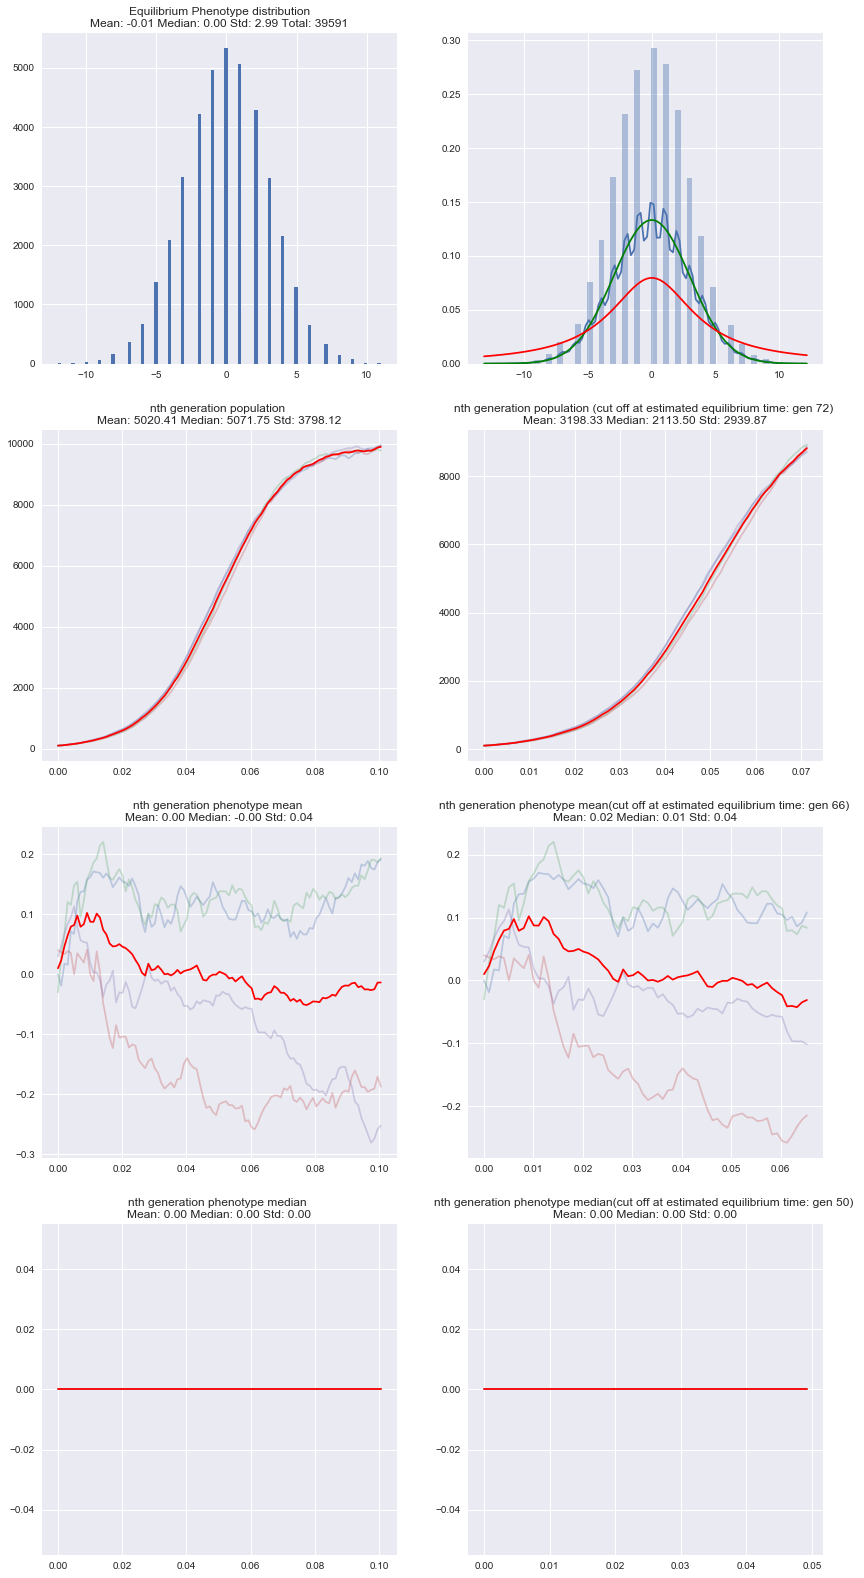

In [25]:
test_sim.add_realisation(2, verbose=True*0)
a = test_sim.report_avg_realisation()

In [66]:
cauchy_sim = Simulate_Continuous(num_init=50, init_dist=None, 
                                 gamma=100, kappa=0.05, epsilon=100, mutation_rate=0.1, 
                                 tau=0.001, delta=0.01, num_generation=100, 
                                 walk_generator=lambda : stats.cauchy(loc=0, scale=1).rvs(1))

Number of realisations: 10


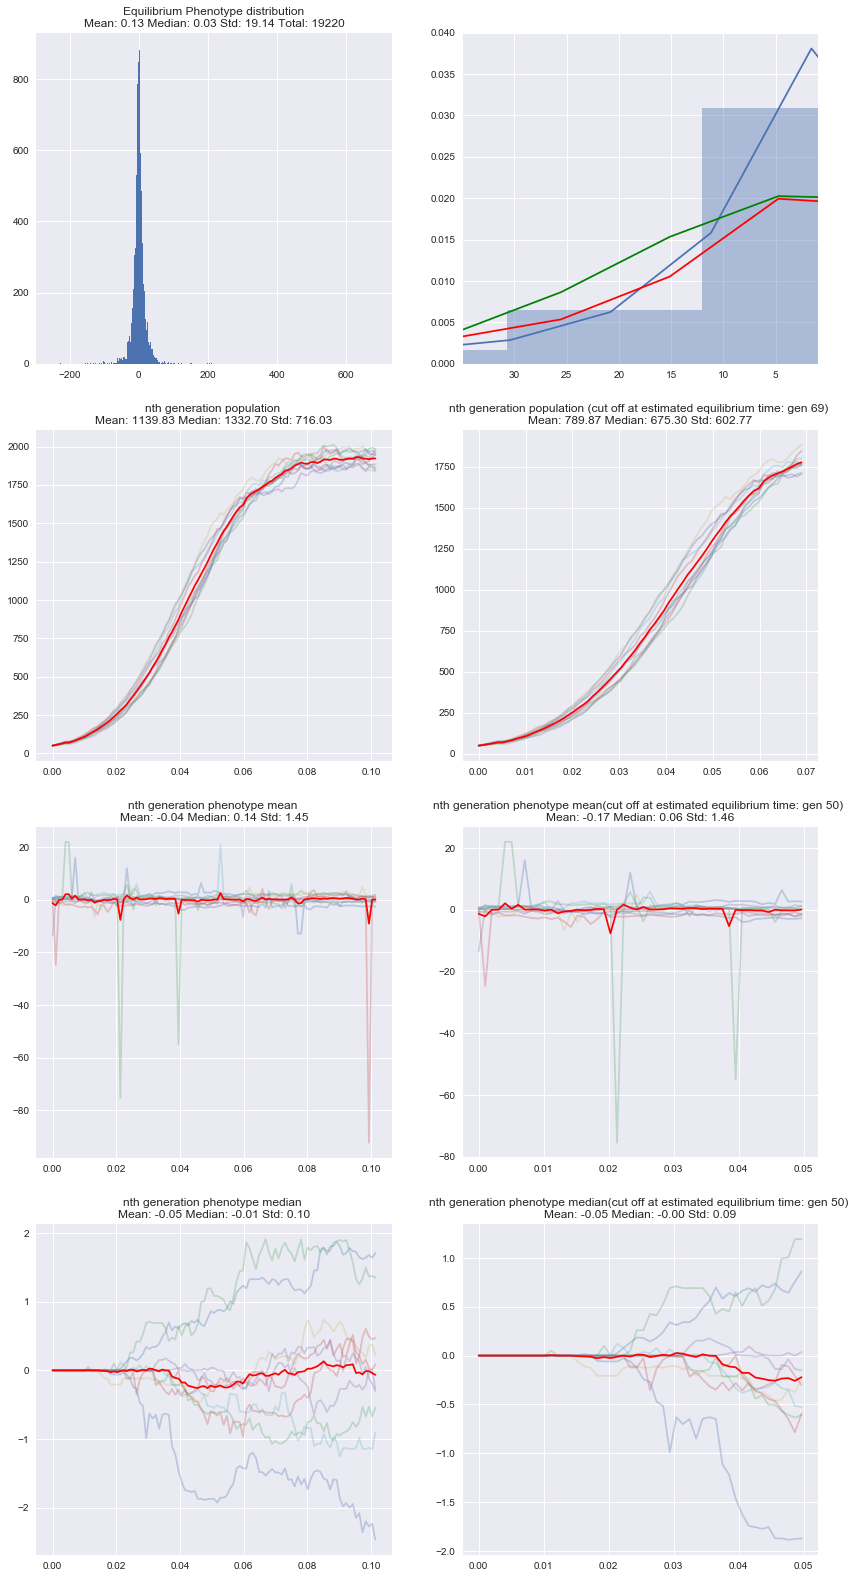

In [70]:
cauchy_sim.add_realisation(3,verbose=False)
a = cauchy_sim.report_avg_realisation()

In [75]:
c_agents_n = np.concatenate([realise['agents'] for realise in cauchy_sim.realisations])
equi_mean = c_agents_n.mean()
equi_num_agents = c_agents_n.size
equi_median = np.median(c_agents_n)
equi_std = np.std(c_agents_n)
equi_iqr = stats.iqr(c_agents_n)
print equi_mean, equi_std

0.1250679099 19.1367918904


867
(-100.0, 100.0)


/Users/edmundlau/Desktop/working_dir/python_env/lib/python2.7/site-packages/matplotlib/legend.py:634: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x121117790>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)


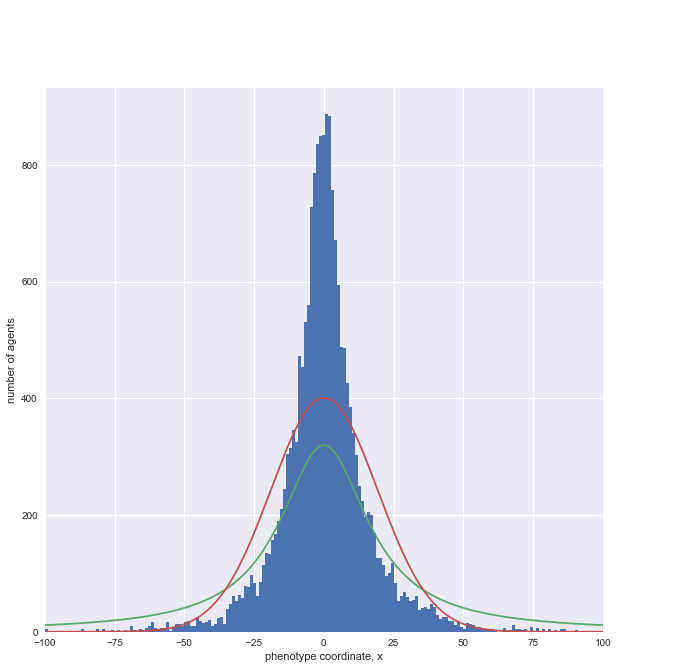

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
lim = (-100, 100)
ax.set_xlim(lim)
bins = compute_bins(c_agents_n)
print bins
a1 = ax.hist(c_agents_n, bins = bins , normed=False)
xlim = ax.get_xlim()
print xlim
axis = np.linspace(xlim[0], xlim[1], num=1000)
a2 = ax.plot(axis, len(c_agents_n) * stats.cauchy.pdf(axis, loc=equi_median, scale=equi_std))
a2 = ax.plot(axis, len(c_agents_n) * stats.norm.pdf(axis, loc=equi_mean, scale=equi_std))

ax.set_ylabel('number of agents')
ax.set_xlabel('phenotype coordinate, x')

plot_list = [a2]
fig.legend(plot_list, ("Fitted Gaussian"), loc='upper right')
fig.savefig('/Users/edmundlau/Desktop/gaussian_eq_dist.png')

In [165]:
cauchy_sim2 = Simulate_Continuous(num_init=50, init_dist=None, 
                                 gamma=100, kappa=0.02, epsilon=100, mutation_rate=0.1, 
                                 tau=0.001, delta=0.01, num_generation=300, 
                                 walk_generator=lambda : stats.cauchy(loc=0, scale=1).rvs(1))

gen: 0, t: 0.0010 n_updates: 5 prev_size: 50 size: 51 
events: [1, 0, 4] b: 0.010583 d: 1.176776

gen: 10, t: 0.0011 n_updates: 25 prev_size: 128 size: 140 
events: [12, 0, 13] b: 0.010772 d: 0.347231

gen: 20, t: 0.0010 n_updates: 58 prev_size: 304 size: 323 
events: [21, 2, 35] b: 0.009923 d: 0.152895

gen: 30, t: 0.0010 n_updates: 147 prev_size: 629 size: 692 
events: [74, 11, 62] b: 0.009553 d: 0.072638

gen: 40, t: 0.0010 n_updates: 284 prev_size: 1316 size: 1409 
events: [131, 38, 115] b: 0.009992 d: 0.037373

gen: 50, t: 0.0010 n_updates: 541 prev_size: 2317 size: 2436 
events: [224, 105, 212] b: 0.010134 d: 0.020941

gen: 60, t: 0.0010 n_updates: 902 prev_size: 3339 size: 3409 
events: [321, 251, 330] b: 0.010145 d: 0.014148

gen: 70, t: 0.0010 n_updates: 1072 prev_size: 4126 size: 4146 
events: [365, 345, 362] b: 0.010087 d: 0.011649

gen: 80, t: 0.0010 n_updates: 1236 prev_size: 4469 size: 4524 
events: [431, 376, 429] b: 0.010015 d: 0.011020

gen: 90, t: 0.0010 n_updates: 13

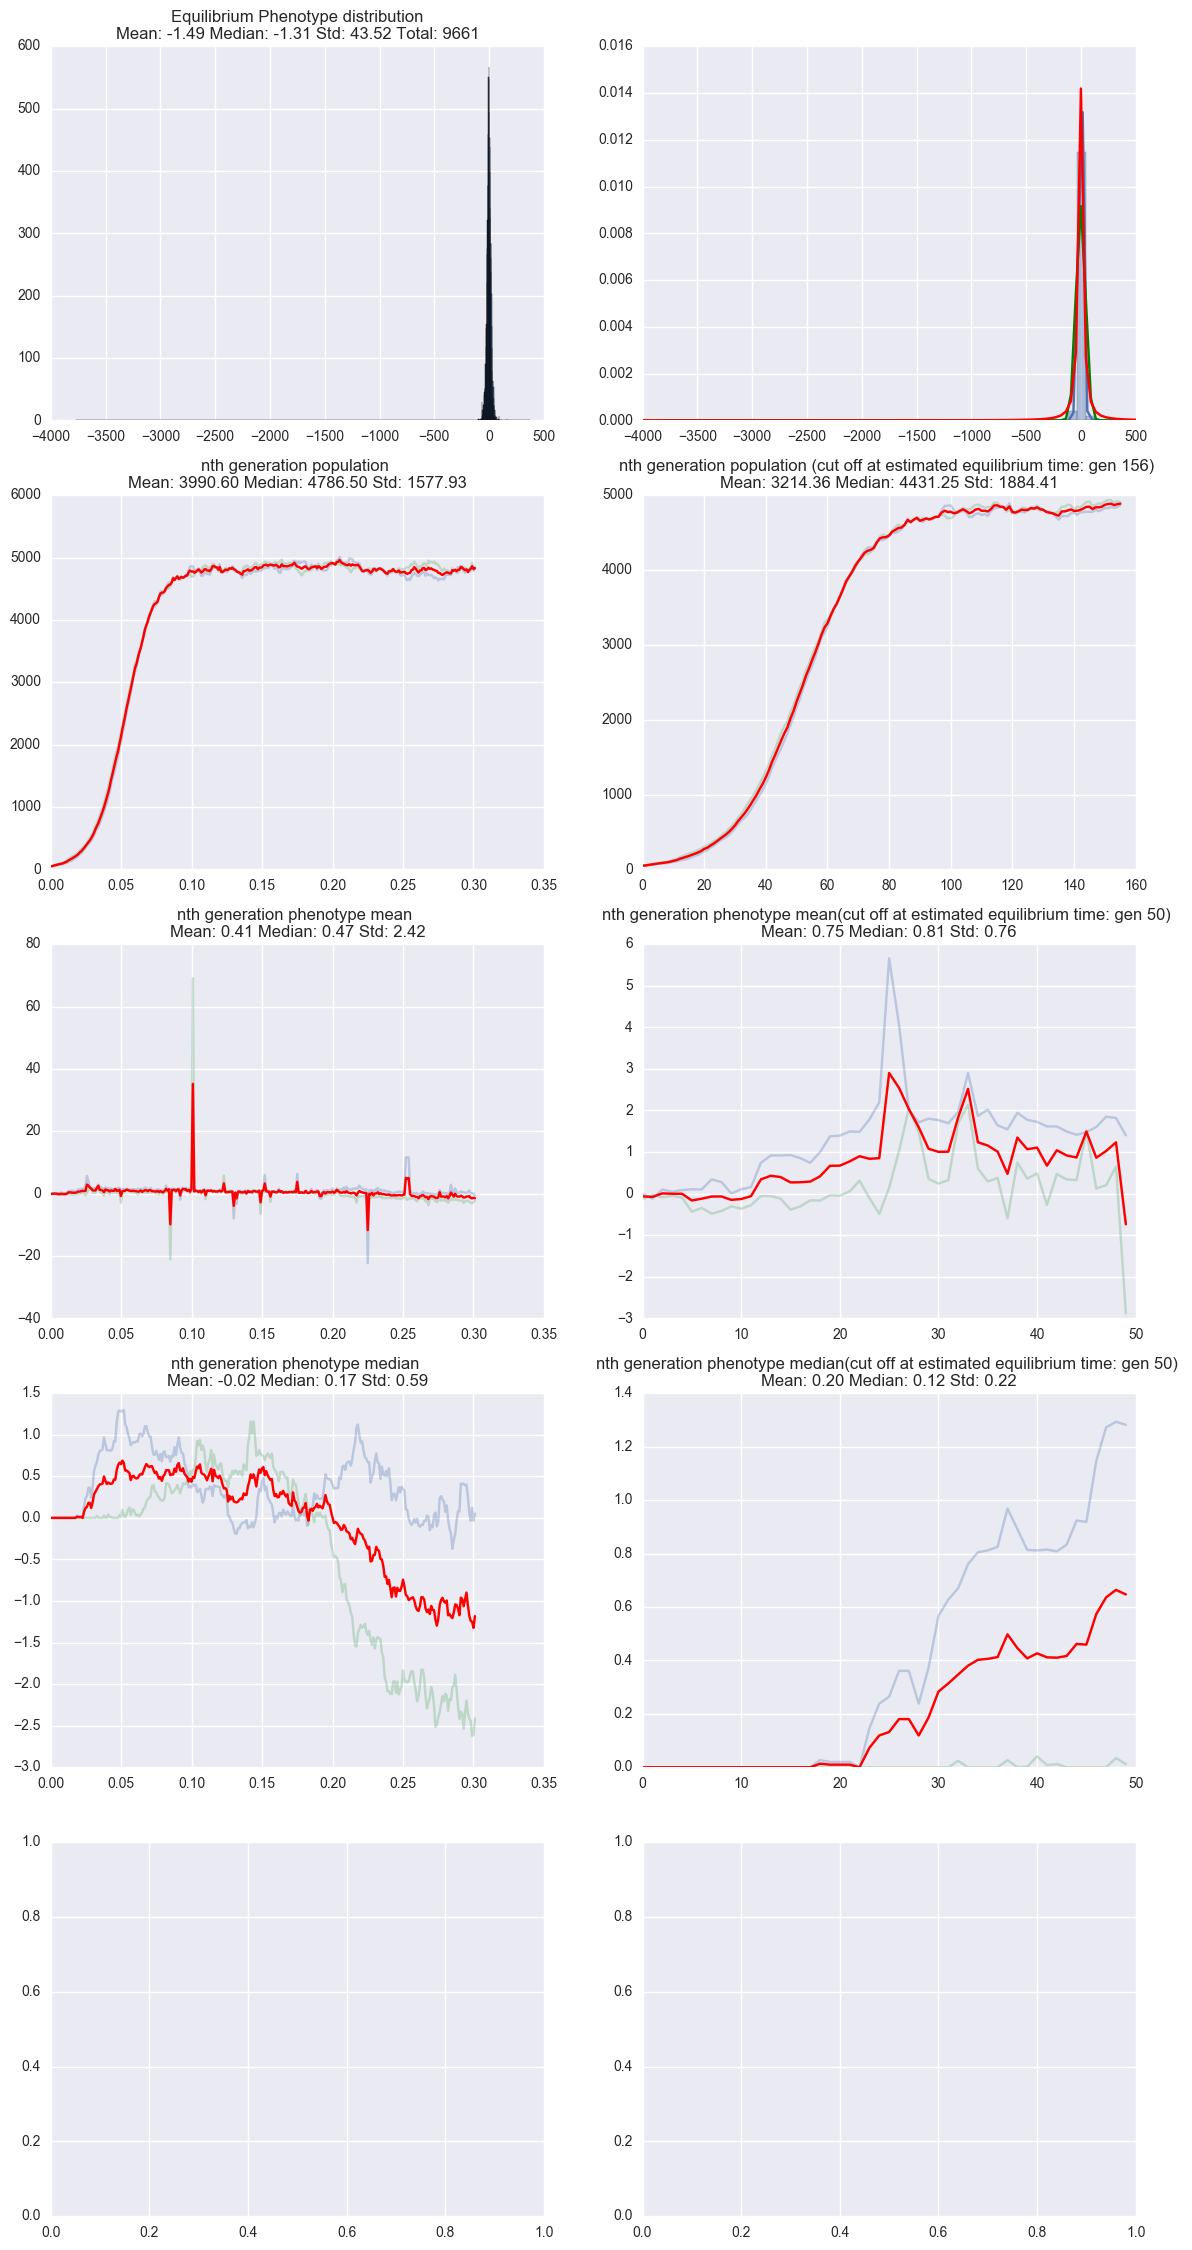

In [167]:
cauchy_sim2.add_realisation(1,verbose=True)
a = cauchy_sim2.report_avg_realisation()

In [8]:
test_sim2 = Simulate_Continuous(num_init=500, init_dist=None, 
                               gamma=100, kappa=0.01, epsilon=100, mutation_rate=0.1, 
                               tau=0.01, delta=0.01, num_generation=100, 
                               walk_generator=lambda : nearest_neighbor_walk(1, 1, 1))

Number of realisations: 10


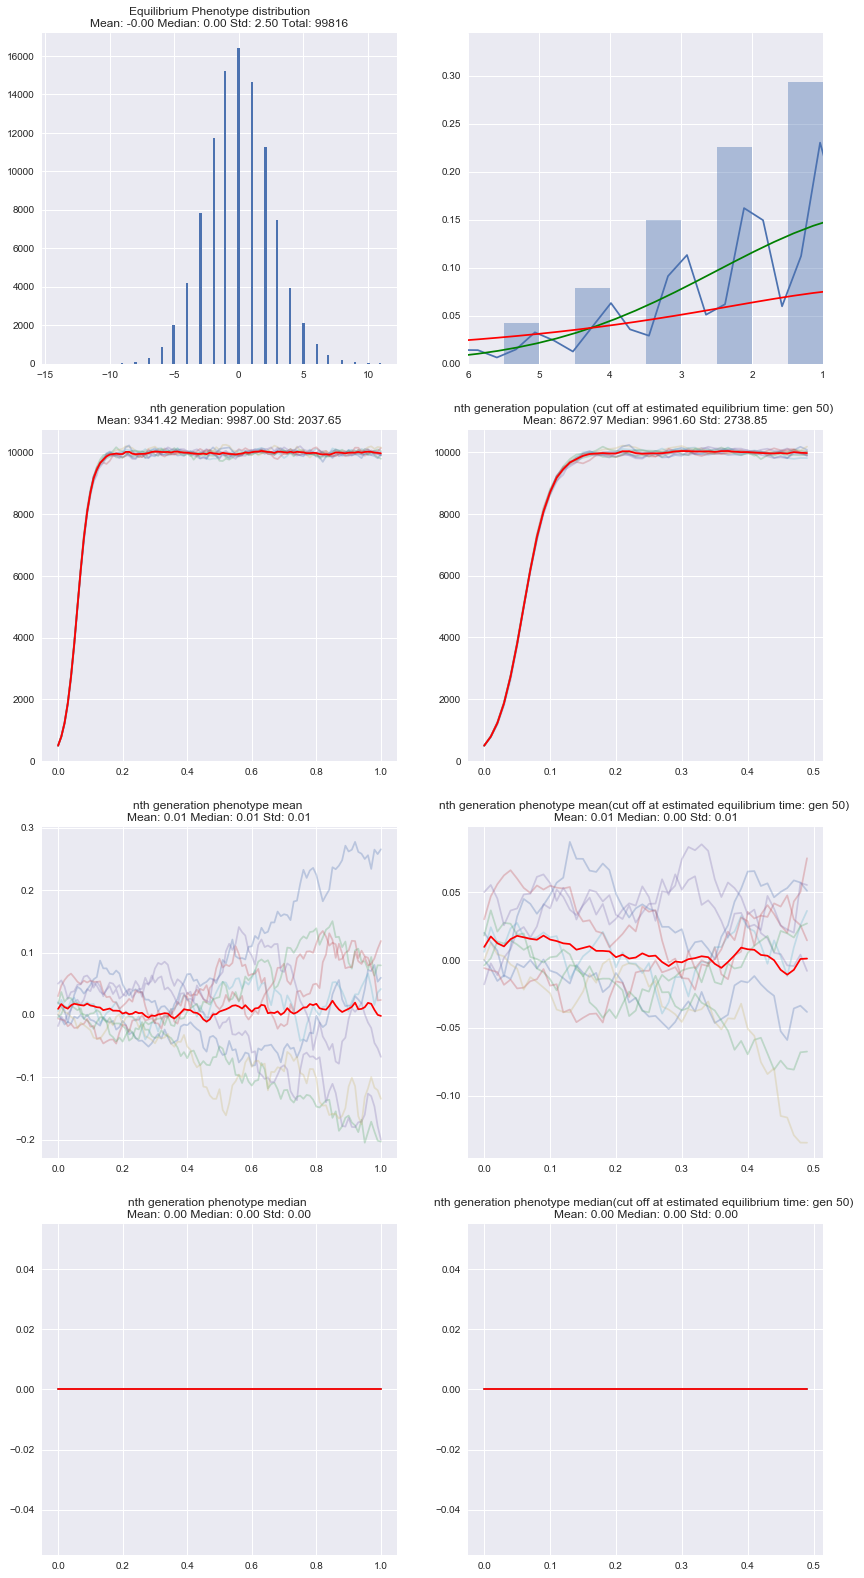

In [50]:
test_sim2.add_realisation(4)
a = test_sim2.report_avg_realisation()

In [51]:
agents_n = np.concatenate([realise['agents'] for realise in test_sim2.realisations])
equi_mean = agents_n.mean()
equi_num_agents = agents_n.size
equi_median = np.median(agents_n)
equi_std = np.std(agents_n)
equi_iqr = stats.iqr(agents_n)
print equi_mean, equi_std
#plt.hist(agents_n, normed=True)

-0.00251462691352 2.50306850403


(-15.25, 12.25)


/Users/edmundlau/Desktop/working_dir/python_env/lib/python2.7/site-packages/matplotlib/legend.py:634: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x11cefe250>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)


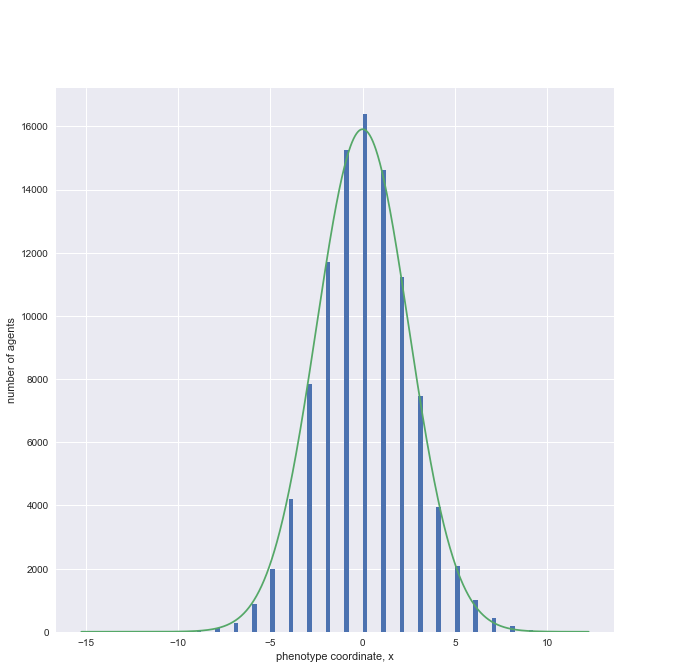

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
a1 = ax.hist(agents_n, bins=100)
xlim = ax.get_xlim()
print xlim
axis = np.linspace(xlim[0], xlim[1], num=1000)
a2 = ax.plot(axis, len(agents_n) * stats.norm.pdf(axis, loc=equi_mean, scale=equi_std))

ax.set_ylabel('number of agents')
ax.set_xlabel('phenotype coordinate, x')

plot_list = [a2]
fig.legend(plot_list, ("Fitted Gaussian"), loc='upper right')
fig.savefig('/Users/edmundlau/Desktop/gaussian_eq_dist.png')
#ax.set_title("Equilibrium Distribution (Nearest Neighbour Random Walk)")

In [ ]:
plt.plot(stats.norm.pdf(np.linspace(-, )))

## Trial continuous time simulation
---
Let's try to write a single realisation with fixed parameters to get the hang of it. 

9796 -0.00163331972234 7.201398776


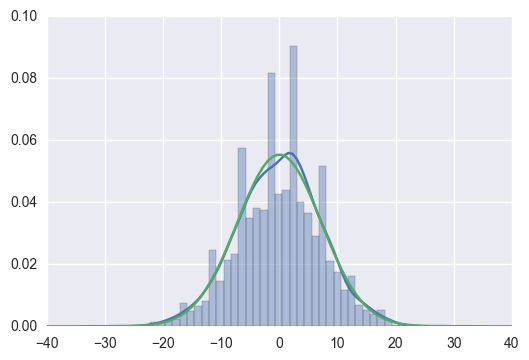

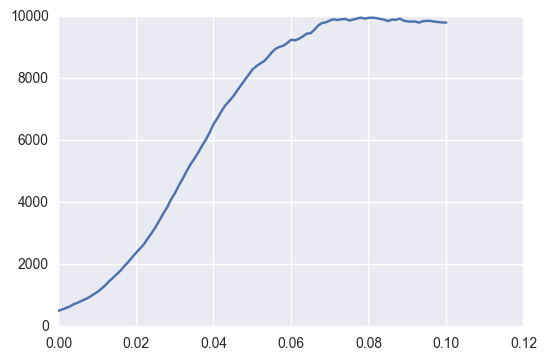

In [9]:
#%%time
# agent-based model param
tau = 0.001
delta = 0.01
gamma = 100
epsilon = 100
kappa = 0.01
num_init = 500
p = 0.9
h = 1
# simulation param
num_generation = 100

agents = np.zeros(num_init) # delta function initial distribution
pop_n = [agents.size]
ts = [0]
rvs = lambda n: nearest_neighbor_walk(n, 1, h)
mutation_rate = p / tau # exponential clock rate for mutation (random walk) to occur

t = 0
for n in range(num_generation):
    t = 0
    num_agents = agents.size
    dn = kappa * num_agents
    walk_clocks = random_exp_time(num_agents, mutation_rate) # walk rate ~ 0.01
    death_clocks = random_exp_time(num_agents, dn) # death rate ~ 5
    birth_clocks = np.zeros(num_agents)
    for i in range(num_agents):
        coord = agents[i]
        bn = gamma - epsilon * (delta * coord)**2 # birth rate ~ 50000 - 0.01 * coord **2
        birth_clocks[i] = random_exp_time(1, bn)
    clocks = np.concatenate([birth_clocks, death_clocks, walk_clocks])
    #agent_indices = np.concatenate([range(num_agents), range(num_agents), range(num_agents)])
    #events = np.concatenate([np.zeros(num_agents, dtype=np.int), 
    #                         np.ones(num_agents, dtype=np.int), 
    #                         np.ones(num_agents, dtype=np.int) * 2])
    sorted_index = clocks.argsort()
    new_agents = []
    remove_index = []
    event_tally = [0, 0, 0]
    j = 0
    t = 0
    while t < tau and j < sorted_index.size:
        index = sorted_index[j]
        event = index // num_agents
        agent_index = index % num_agents
       
        event_tally[event] += 1
        if event == 0: # birth
            new_agents.append(agents[agent_index])
        elif event == 1: # death
            remove_index.append(agent_index)
        elif event == 2: # walk
            agents[agent_index] += rvs(1)
        else:
            raise RuntimeError
        j += 1
        t = clocks[index]
    agents = np.delete(agents, remove_index)
    agents = np.append(agents, new_agents)
    pop_n.append(agents.size)
    ts.append(ts[-1] + t)
    #print agents.size
    if n % 10 == 0:
        #continue
        print ("t: %.4f n_updates: %i n: %i size: %i events: %s b: %f d: %f, new: %i, death: %i" 
               % (t, j, num_agents, agents.size, str(event_tally), 
                  birth_clocks.mean(), death_clocks.mean(), len(new_agents), len(remove_index)))
ax = plt.subplot(111)
sns.distplot(agents, ax=ax)
xmin, xmax = ax.get_xlim()
std = np.std(agents)
mean = agents.mean()
print agents.size, mean, std
xaxis = np.linspace(xmin, xmax, num=100)
ax.plot(xaxis, stats.norm.pdf(xaxis, loc=mean, scale=std))
plt.figure()
plt.plot(ts, pop_n)

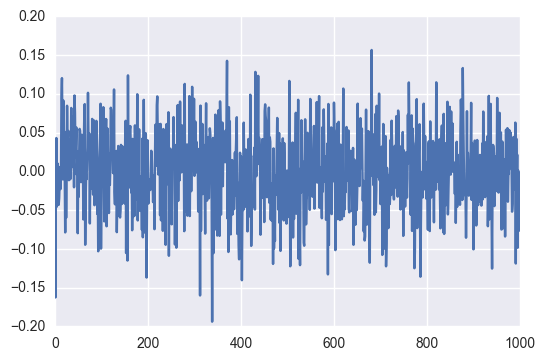

In [73]:
y = [np.median(stats.cauchy(loc=0, scale=1).rvs(1000)) for i in range(1000)]
plt.plot(range(1000), y) 

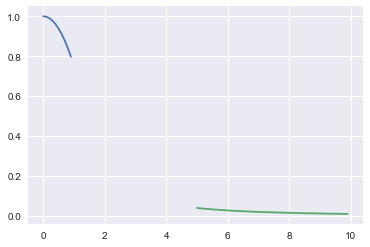

In [13]:
x1 = np.arange(0, 1, 0.1)
y1 = -(0.5 * x1) **2 + 1
x2 = np.arange(5, 10, 0.1)
y2 = 1.0 / (x2 **2)

plt.plot(x1, y1, x2, y2)
plt.savefig("/Users/edmundlau/Desktop/figure.png", format='png')